#### Importing necessary libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from datetime import datetime, timedelta

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#### Defining a list of stock tickers

In [2]:
#tickers = ['NVDA', 'TSLA', 'CELH', 'META', 'AAPL', 'MSFT', 'NFLX', 'GOOGL', 'AMD', 'AMZN']
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "JPM", "PYPL",
           "INTC", "CSCO", "DIS", "IBM", "CELH", "WMT", "CVX", "PFE", "AMD", 
           "PEP", "NFLX", "COST"]


#### Setting up start and end dates for data retrieval

In [3]:
end_date = datetime.today()
start_date = end_date - timedelta(days = 5*365)

#### Retrieving adjusted close prices for each ticker and storing in a DataFrame

In [4]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [5]:
adj_close_df.head()

,AAPL,MSFT,GOOGL,AMZN,TSLA,NVDA,JPM,PYPL,INTC,CSCO,DIS,IBM,CELH,WMT,CVX,PFE,AMD,PEP,NFLX,COST
Date,,,,,,,,,,,,,,,,,,,,
2019-02-11,40.829552,99.945099,55.105999,79.550003,20.856001,36.328106,86.852127,92.690002,42.679138,40.883411,107.767433,101.539612,1.206667,88.527351,93.858894,32.459084,22.959999,98.067390,345.730011,191.298462
2019-02-12,41.181389,101.502426,56.379002,81.900497,20.787333,37.498951,88.332954,94.379997,43.764278,41.149780,107.531097,103.100700,1.183333,89.235939,95.279434,32.607052,22.820000,98.779236,359.970001,194.213043
2019-02-13,41.010288,101.426483,56.431499,82.000000,20.544666,37.923126,88.754799,94.010002,44.166828,40.814678,108.515823,104.214691,1.166667,90.128578,95.961601,32.474667,22.850000,99.065681,351.769989,195.037949
2019-02-14,41.159695,101.511925,56.459999,81.132500,20.251333,38.332428,88.177979,94.419998,44.464367,41.588005,108.968796,103.426559,1.143333,90.662308,95.783257,32.684929,23.129999,97.737526,359.070007,195.991135
2019-02-15,41.068123,102.765396,55.981499,80.397499,20.525333,39.029472,90.872749,94.910004,45.208202,42.473038,110.869286,104.601189,1.173333,92.015076,96.747887,33.019798,23.680000,100.619568,356.869995,198.401627


In [6]:
'''
plt.figure(figsize=(10, 6))
sns.histplot(adj_close_df['TSLA'], kde=True, color='blue', bins=30)
plt.title('Distribution of Tesla Stock Prices')
plt.xlabel('Stock Price (Adj Close)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(adj_close_df['GOOGL'], kde=True, color='blue', bins=30)
plt.title('Distribution of Google Stock Prices')
plt.xlabel('Stock Price (Adj Close)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(adj_close_df['AAPL'], kde=True, color='blue', bins=30)
plt.title('Distribution of Apple Stock Prices')
plt.xlabel('Stock Price (Adj Close)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(adj_close_df['CELH'], kde=True, color='blue', bins=30)
plt.title('Distribution of Celsius Holdings Stock Prices')
plt.xlabel('Stock Price (Adj Close)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(adj_close_df['NFLX'], kde=True, color='blue', bins=30)
plt.title('Distribution of Netflix Stock Prices')
plt.xlabel('Stock Price (Adj Close)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(adj_close_df['MSFT'], kde=True, color='blue', bins=30)
plt.title('Distribution of Microsoft Stock Prices')
plt.xlabel('Stock Price (Adj Close)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(adj_close_df['NVDA'], kde=True, color='blue', bins=30)
plt.title('Distribution of NVIDIA Stock Prices')
plt.xlabel('Stock Price (Adj Close)')
plt.ylabel('Frequency')
plt.show()

'''

"\nplt.figure(figsize=(10, 6))\nsns.histplot(adj_close_df['TSLA'], kde=True, color='blue', bins=30)\nplt.title('Distribution of Tesla Stock Prices')\nplt.xlabel('Stock Price (Adj Close)')\nplt.ylabel('Frequency')\nplt.show()\n\nplt.figure(figsize=(10, 6))\nsns.histplot(adj_close_df['GOOGL'], kde=True, color='blue', bins=30)\nplt.title('Distribution of Google Stock Prices')\nplt.xlabel('Stock Price (Adj Close)')\nplt.ylabel('Frequency')\nplt.show()\n\nplt.figure(figsize=(10, 6))\nsns.histplot(adj_close_df['AAPL'], kde=True, color='blue', bins=30)\nplt.title('Distribution of Apple Stock Prices')\nplt.xlabel('Stock Price (Adj Close)')\nplt.ylabel('Frequency')\nplt.show()\n\nplt.figure(figsize=(10, 6))\nsns.histplot(adj_close_df['CELH'], kde=True, color='blue', bins=30)\nplt.title('Distribution of Celsius Holdings Stock Prices')\nplt.xlabel('Stock Price (Adj Close)')\nplt.ylabel('Frequency')\nplt.show()\n\nplt.figure(figsize=(10, 6))\nsns.histplot(adj_close_df['NFLX'], kde=True, color='blu

#### Calculating log returns

In [7]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns

,AAPL,MSFT,GOOGL,AMZN,TSLA,NVDA,JPM,PYPL,INTC,CSCO,DIS,IBM,CELH,WMT,CVX,PFE,AMD,PEP,NFLX,COST
Date,,,,,,,,,,,,,,,,,,,,
2019-02-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-12,0.008580,0.015462,0.022838,0.029119,-0.003298,0.031721,0.016906,0.018069,0.025108,0.006494,-0.002195,0.015257,-0.019527,0.007972,0.015021,0.004548,-0.006116,0.007233,0.040363,0.015121
2019-02-13,-0.004163,-0.000748,0.000931,0.001214,-0.011742,0.011248,0.004764,-0.003928,0.009156,-0.008177,0.009116,0.010747,-0.014184,0.009953,0.007134,-0.004068,0.001314,0.002896,-0.023043,0.004238
2019-02-14,0.003637,0.000842,0.000505,-0.010636,-0.014381,0.010735,-0.006520,0.004352,0.006714,0.018770,0.004166,-0.007591,-0.020203,0.005904,-0.001860,0.006454,0.012179,-0.013498,0.020540,0.004875
2019-02-15,-0.002227,0.012272,-0.008511,-0.009101,0.013439,0.018021,0.030103,0.005176,0.016590,0.021058,0.017290,0.011293,0.025901,0.014811,0.010021,0.010193,0.023500,0.029061,-0.006146,0.012224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-01,0.013252,0.015474,0.007538,0.025949,0.008348,0.024087,-0.003620,0.010862,0.006478,0.000000,0.010460,0.017487,0.023763,0.018348,0.003115,0.007725,0.016501,0.018635,0.006009,0.015190
2024-02-02,-0.005420,0.018258,0.008606,0.075726,-0.005043,0.048513,0.005740,0.006429,-0.017683,0.000000,0.000721,-0.005957,0.043089,0.007458,0.028990,-0.013279,0.041254,-0.004261,-0.005070,0.007072
2024-02-05,0.009798,-0.013638,0.009089,-0.008769,-0.037135,0.046831,-0.001317,-0.014198,0.003983,-0.013442,-0.004954,-0.012838,-0.002628,-0.005381,0.000591,-0.013458,-0.019495,-0.000293,-0.004580,0.002365


#### Counting NaN values in log returns

In [8]:
log_returns.isna().sum()

AAPL     1
MSFT     1
GOOGL    1
AMZN     1
TSLA     1
NVDA     1
JPM      1
PYPL     1
INTC     1
CSCO     1
DIS      1
IBM      1
CELH     1
WMT      1
CVX      1
PFE      1
AMD      1
PEP      1
NFLX     1
COST     1
dtype: int64

#### Calculating mean log returns

In [9]:
log_returns.mean()

AAPL     0.001222
MSFT     0.001132
GOOGL    0.000773
AMZN     0.000607
TSLA     0.001749
NVDA     0.002357
JPM      0.000560
PYPL    -0.000304
INTC     0.000002
CSCO     0.000157
DIS     -0.000066
IBM      0.000472
CELH     0.003080
WMT      0.000517
CVX      0.000385
PFE     -0.000130
AMD      0.001598
PEP      0.000445
NFLX     0.000383
COST     0.001055
dtype: float64

#### Dropping NaN values from log returns

In [10]:
log_returns.dropna(inplace=True)

#### Calculating covariance matrix of log returns

In [11]:
cov_matrix = log_returns.cov() * 252
cov_matrix

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,AAPL,MSFT,GOOGL,AMZN,TSLA,NVDA,JPM,PYPL,INTC,CSCO,DIS,IBM,CELH,WMT,CVX,PFE,AMD,PEP,NFLX,COST
AAPL,0.100709,0.073022,0.068329,0.068752,0.101838,0.107954,0.046214,0.080279,0.070008,0.051244,0.049970,0.036674,0.084289,0.026998,0.040569,0.025916,0.096833,0.036282,0.068343,0.042781
MSFT,0.073022,0.091989,0.073261,0.072720,0.090351,0.110699,0.043526,0.079126,0.068973,0.049486,0.050203,0.035201,0.083791,0.026991,0.038795,0.027367,0.098988,0.036451,0.068055,0.042254
GOOGL,0.068329,0.073261,0.101493,0.073407,0.083926,0.102907,0.044441,0.075510,0.065202,0.045966,0.052130,0.033826,0.081153,0.022633,0.040135,0.024594,0.094245,0.030257,0.067653,0.037607
AMZN,0.068752,0.072720,0.073407,0.123011,0.098857,0.109067,0.031423,0.085460,0.060698,0.039945,0.049912,0.025680,0.091300,0.024176,0.022422,0.018145,0.104578,0.025479,0.088863,0.042355
TSLA,0.101838,0.090351,0.083926,0.098857,0.417732,0.168310,0.058812,0.127154,0.090482,0.049371,0.069065,0.031752,0.151918,0.021947,0.053693,0.018129,0.152086,0.029227,0.109591,0.050845
NVDA,0.107954,0.110699,0.102907,0.109067,0.168310,0.258396,0.062229,0.126449,0.109803,0.067804,0.072043,0.045417,0.153747,0.032609,0.054255,0.028442,0.202839,0.040029,0.113794,0.059671
JPM,0.046214,0.043526,0.044441,0.031423,0.058812,0.062229,0.101224,0.053675,0.055711,0.045516,0.062501,0.050159,0.071510,0.018557,0.073570,0.030185,0.054787,0.031960,0.030731,0.024465
PYPL,0.080279,0.079126,0.075510,0.085460,0.127154,0.126449,0.053675,0.196597,0.076738,0.049879,0.068681,0.033701,0.116544,0.027253,0.046238,0.025149,0.109366,0.035376,0.098702,0.041814
INTC,0.070008,0.068973,0.065202,0.060698,0.090482,0.109803,0.055711,0.076738,0.154082,0.056376,0.054696,0.048717,0.089068,0.026478,0.051226,0.029698,0.102332,0.036259,0.066041,0.040697
CSCO,0.051244,0.049486,0.045966,0.039945,0.049371,0.067804,0.045516,0.049879,0.056376,0.080544,0.045624,0.042823,0.050372,0.025099,0.042120,0.030062,0.063966,0.033051,0.035769,0.033125


#### Heatmap of correlation between log returns of all assets

<Axes: >

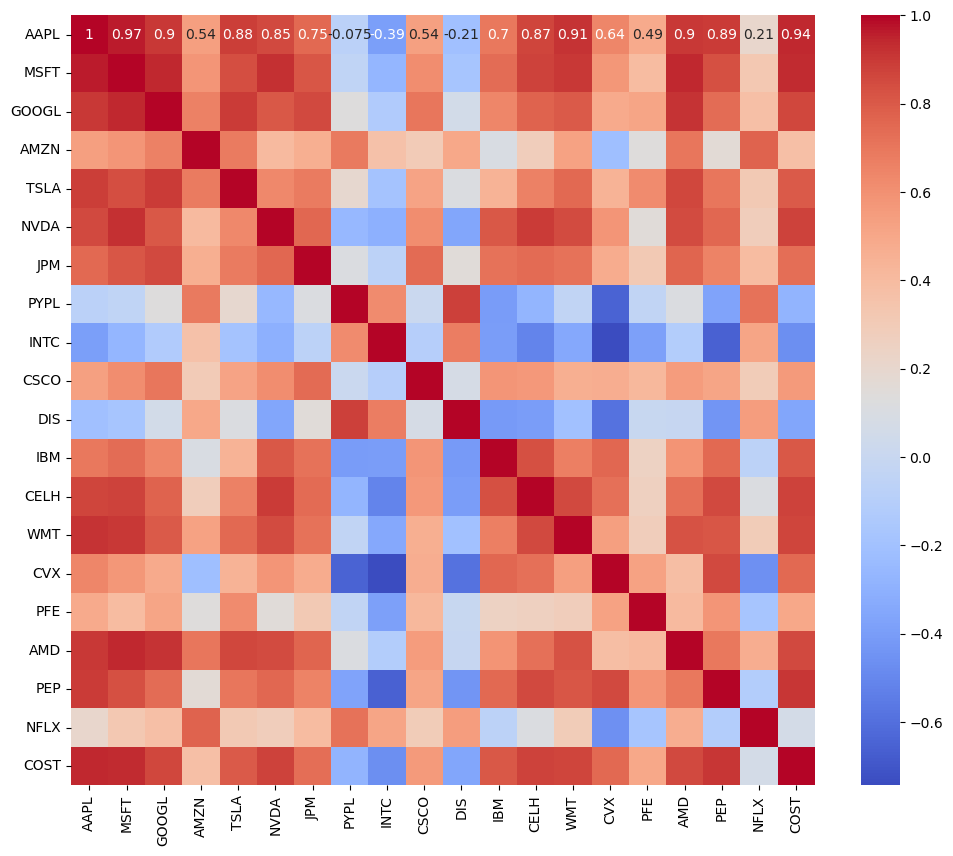

In [13]:
import matplotlib.pyplot as plt

corr_matrix = adj_close_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

#### Defining a function to calculate standard deviation

In [14]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

#### Defining a function to calculate expected annualized returns

In [15]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights*252)

#### Defining a function to calculate the sharpe ratio

In [16]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

#### Retrieving risk-free rate from FRED API

In [17]:
from fredapi import Fred

fred = Fred(api_key='37d707ea29d05517c0f3f400b23644bb')
treasury_rate_10y = fred.get_series_latest_release('GS10')/100
risk_free_rate = treasury_rate_10y[-1]
risk_free_rate

/var/folders/t1/r4wwd84d6xb75g5c6kcczbsm0000gn/T/ipykernel_1208/2153171841.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_free_rate = treasury_rate_10y[-1]


0.0406

#### Defining a function to calculate negative Sharpe ratio

In [18]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

#### Defining constraints and bounds for optimization

In [19]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]

#### Setting initial weights for optimization

In [20]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
initial_weights

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

#### Optimizing portfolio weights - Medium risk goal

In [21]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimal_weights = optimized_results.x


#### Printing optimal weights for each ticker

In [22]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

Optimal Weights:
AAPL: 0.0000
MSFT: 0.0000
GOOGL: 0.0000
AMZN: 0.0000
TSLA: 0.0000
NVDA: 0.3084
JPM: 0.0000
PYPL: 0.0000
INTC: 0.0000
CSCO: 0.0000
DIS: 0.0000
IBM: 0.0000
CELH: 0.1916
WMT: 0.0000
CVX: 0.0000
PFE: 0.0000
AMD: 0.0000
PEP: 0.0000
NFLX: 0.0000
COST: 0.5000


#### Calculating expected annual return, volatility, and Sharpe ratio of the optimal portfolio

In [23]:
optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Expected Annual Return: 0.4648
Expected Volatility: 0.3263
Sharpe Ratio: 1.3001


#### Generating samples for plotting Volatility vs Returns with Sharpe Ratio

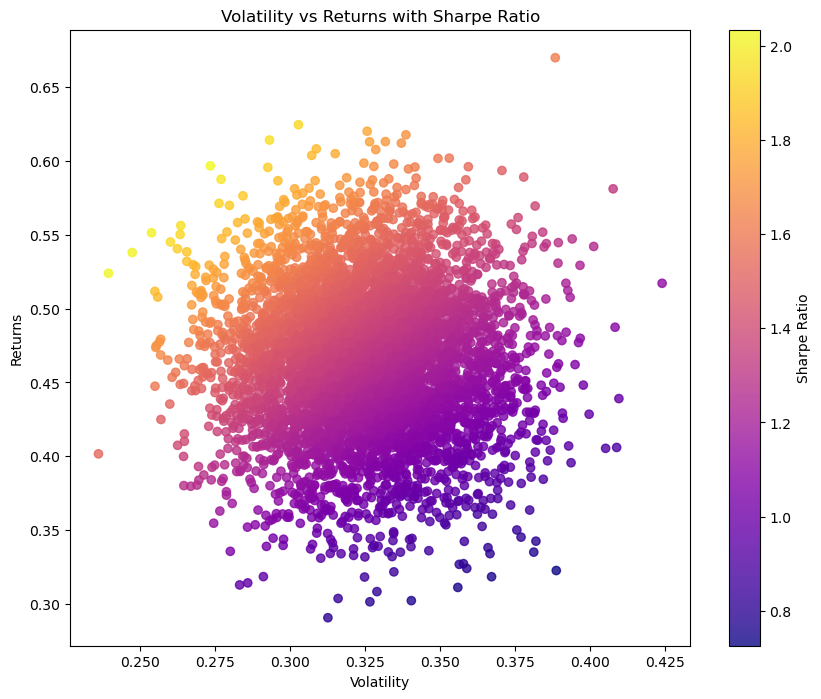

In [24]:
num_samples = 5000

volatility_samples = np.random.normal(optimal_portfolio_volatility, 0.025, num_samples)
returns_samples = np.random.normal(optimal_portfolio_return, 0.05, num_samples)
sharpe_ratio_samples = (returns_samples - risk_free_rate) / volatility_samples

plt.figure(figsize=(10,8))
plt.scatter(volatility_samples, returns_samples, c=sharpe_ratio_samples, cmap='plasma', alpha=0.8)
cbar = plt.colorbar()
cbar.set_label('Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.title('Volatility vs Returns with Sharpe Ratio')
plt.show()



#### Plotting Volatility vs Returns with Sharpe Ratio

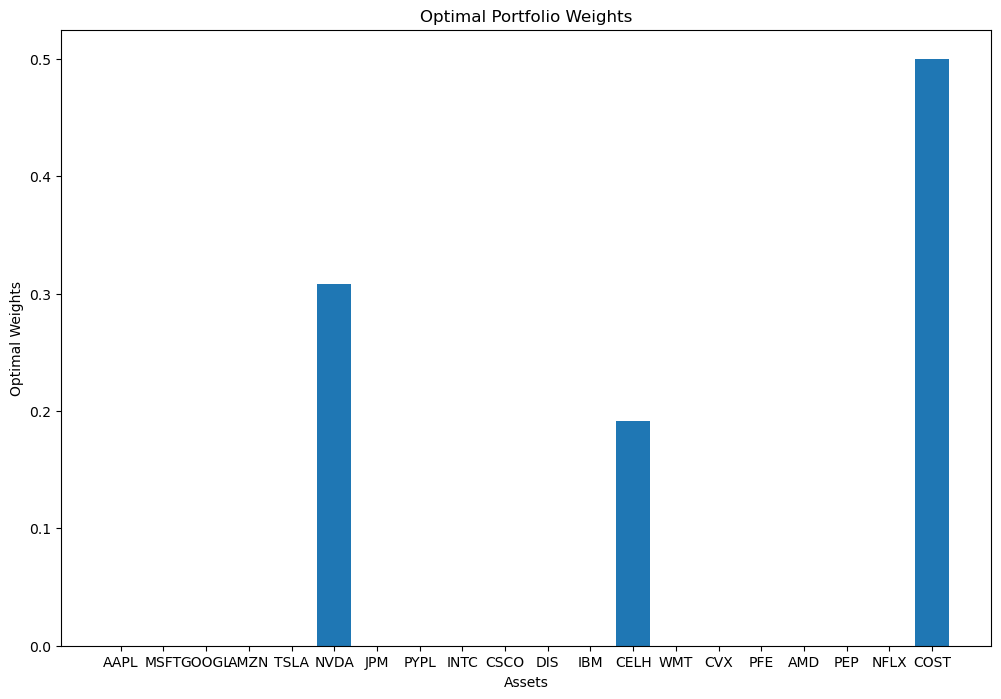

In [25]:
plt.figure(figsize=(12, 8))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()